In [102]:
import pylab as pl
import numpy as np
import pandas as pd
import json
import os
s = json.load( open('fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# TIME SERIES ANALYSIS

## Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## Data:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [103]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [104]:
#reading the datacube
mta = np.load("MTA_Fare.npy")
mta = mta.astype(float)
mta.shape

(600, 23, 194)

In [105]:
# clean up the data
mta[mta==-1] = np.nan

In [106]:
# Sum up fare for all ride types
mta_allsum =np.nansum(mta, axis=0)
mta_allsum = pd.DataFrame(mta_allsum)
mta_allsum.shape

(23, 194)

In [111]:
print mta_allsum.head()
print mta_allsum.loc[0].head()

        0         1         2         3         4         5         6    \
0  11494615  12526859  12766627  12653675  12809694  11429783  12346877   
1    530524    583533    586194    562602    548858    455691    518187   
2     47801     51486     51636     52063     51153     46852     48963   
3    186551    199229    199668    196389    194883    175648    188467   
4     46808     64353     56994     37429     35210     46849     60225   

        7         8         9      ...          184       185       186  \
0  12576759  12437115  12431257    ...     14604028  11344945  11223430   
1    513412    512192    522569    ...       781529    596341    518956   
2     49629     49030     50376    ...        62658     50820     45153   
3    188090    186822    190528    ...       193268    164607    148652   
4     47439     32084     52171    ...        56671     22623     25301   

        187       188       189       190       191       192       193  
0  12864865  12904811  1

In [108]:
date = pd.date_range(start='05/21/2010', end='02/21/2014', freq='W')
date = date[2:]
date.shape

(194,)

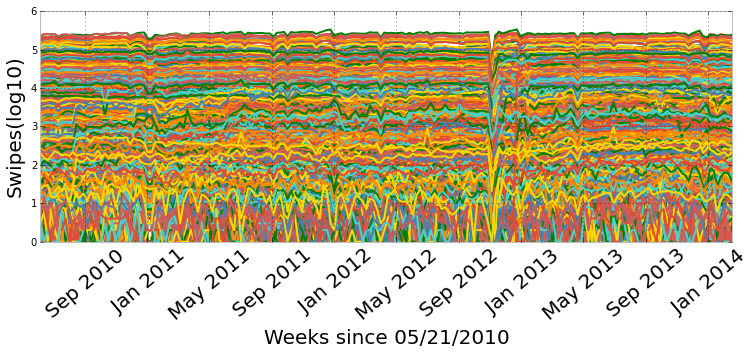

In [109]:
fig = figure(figsize=(12,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xlabel('Weeks since 05/21/2010', size=20)
ax.set_ylabel('Swipes(log10)', size=20)
ax.tick_params(axis='x',labelsize=10)
pl.xticks(rotation=40, fontsize=20)
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        ax.plot(date, np.log10(mta[i,j]))

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.


In [112]:
# test the approach of threshold
thresholds = [mta_allsum.loc[0,:].mean() + 3*mta_allsum.loc[0,:].std(), 
              mta_allsum.loc[0,:].mean() - 3*mta_allsum.loc[0,:].std()]
print thresholds

[16889312.352366973, 9595433.585777357]


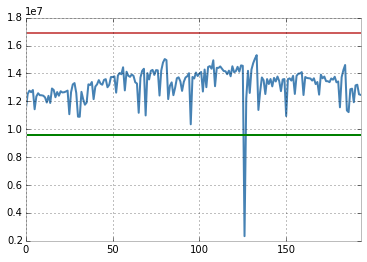

In [113]:
ax = mta_allsum.loc[0].plot()
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])

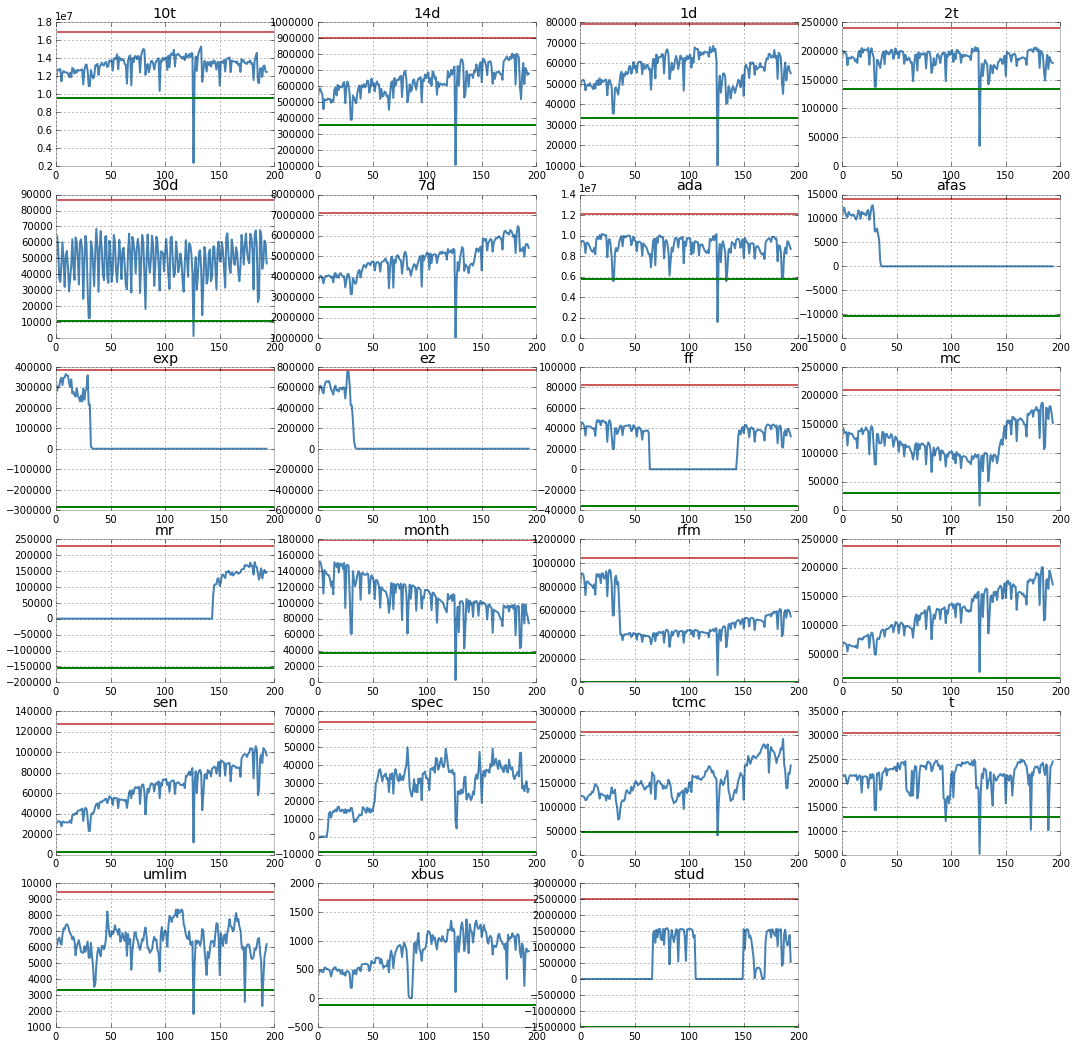

In [114]:
# Plot the week against total ride for all staion.
fig = plt.figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            ax.plot(mta_allsum.loc[i*4+j,:])
            thresholds = [mta_allsum.loc[i*4+j,:].mean() + 3*mta_allsum.loc[i*4+j,:].std(), 
                          mta_allsum.loc[i*4+j,:].mean() - 3*mta_allsum.loc[i*4+j,:].std()]
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
            ax.set_title(ridetype[i*4+j])

In [116]:
# Event detection
events = pd.Series()
for i in range(23):
    thresholds = [mta_allsum.loc[i,:].mean() + 3*mta_allsum.loc[i,:].std(), 
                  mta_allsum.loc[i,:].mean() - 3*mta_allsum.loc[i,:].std()]
    # event = pd.concat([event, pd.Series(date[mta_allsum.index[mta_allsum.loc[i,:]<thresholds[1]]])], axis=0, ignore_index=True)
    event = (mta_allsum.loc[i,:]<thresholds[1])
    events = pd.concat([events, pd.Series(date[event.index[event==True]])], axis=0, ignore_index=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

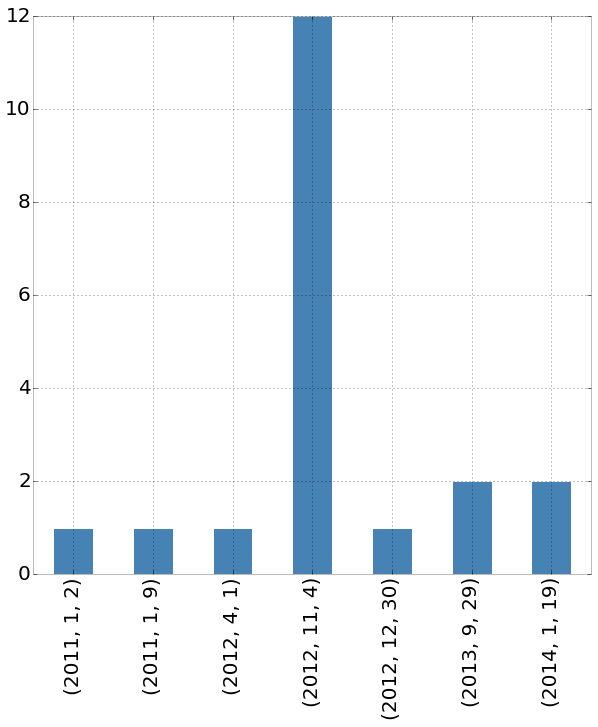

In [117]:
events.sort()
events.groupby([events.dt.year, events.dt.month, events.dt.day]).count().plot(kind="bar",fontsize=20, figsize=(10,10))
pl.xticks(rotation=90)

### My comment:

The sudden drop in MTA fare in November 4, 2012 should be caused by the Hurricane Sandy, which dated from October 22, 2012 to October 31, 2012.

## Task 2:
* Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

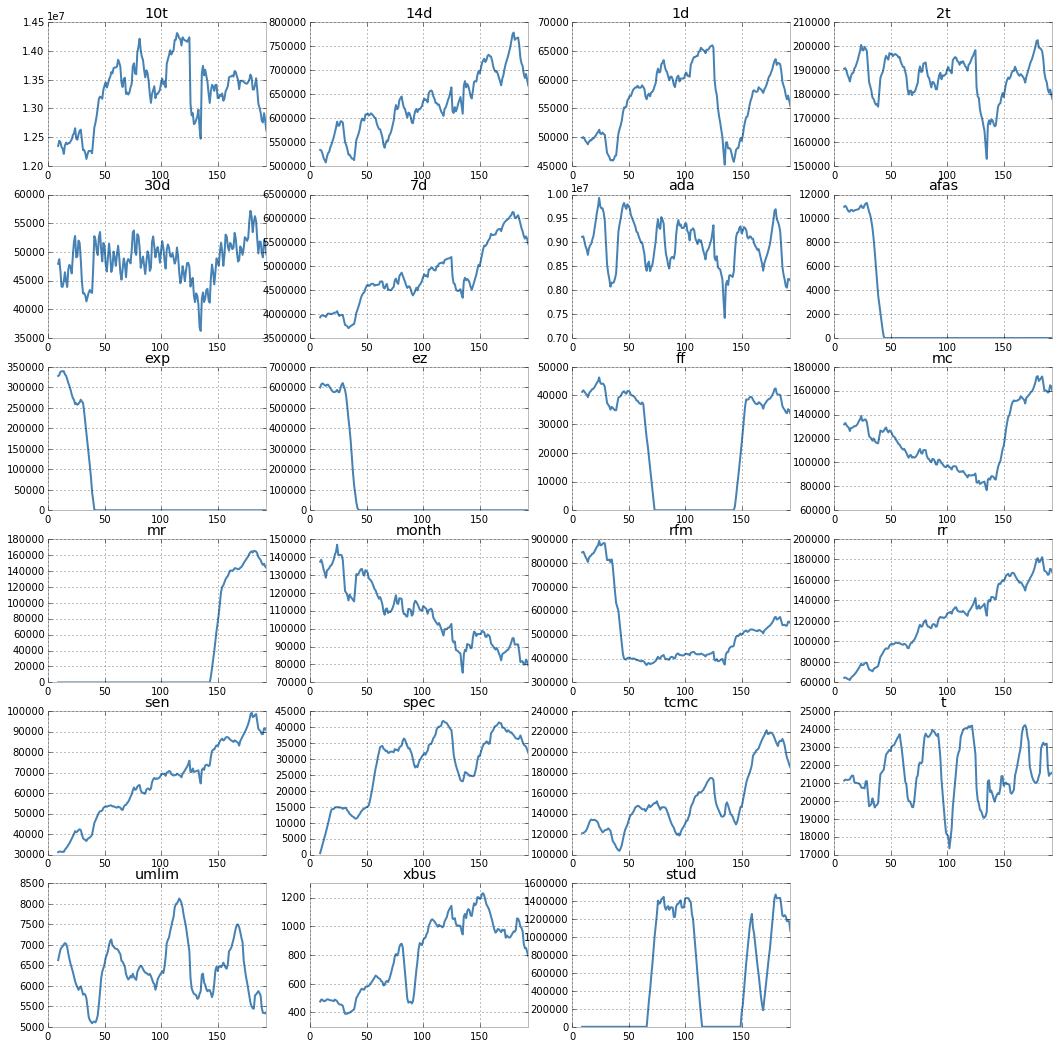

In [119]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
ratio = np.zeros(23)
std = np.zeros(23)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            roll_mean = pd.rolling_mean(mta_allsum.loc[i*4+j,:], 10)
            ax = roll_mean.plot()
            ratio[i*4+j] = roll_mean.loc[9]/roll_mean.loc[193]
            std[i*4+j] = np.nanstd(roll_mean)
            ax.set_title(ridetype[i*4+j])

In [122]:
table = pd.DataFrame({'Type' : ridetype,
                     'Flux Ratio From Beginning to End' : ratio,
                     'Std' : std})
print table

    Flux Ratio From Beginning to End            Std   Type
0                           0.978667  546777.616992    10t
1                           0.798681   64593.901400    14d
2                           0.899810    5767.412494     1d
3                           1.070889    8828.003856     2t
4                           0.967317    3624.088526    30d
5                           0.719555  631955.017784     7d
6                           1.111307  473487.373171    ada
7                        4774.478261    3794.926774   afas
8                       93571.342857  101444.891854    exp
9                      665798.555556  206370.776156     ez
10                          1.221296   18800.946529     ff
11                          0.824035   25371.323554     mc
12                          0.000040   61154.073440     mr
13                          1.727944   17282.833852  month
14                          1.539389  153165.983867    rfm
15                          0.385660   33309.135355     

### My comment:

Through using moving mean, we can see steady increase in ride type "14d" "7d" "ff" "sen"

And steady decrease in ride type "month", while "afas", "exp", "ez" had a steady decrease and a jump to zero

## Task 3:

Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


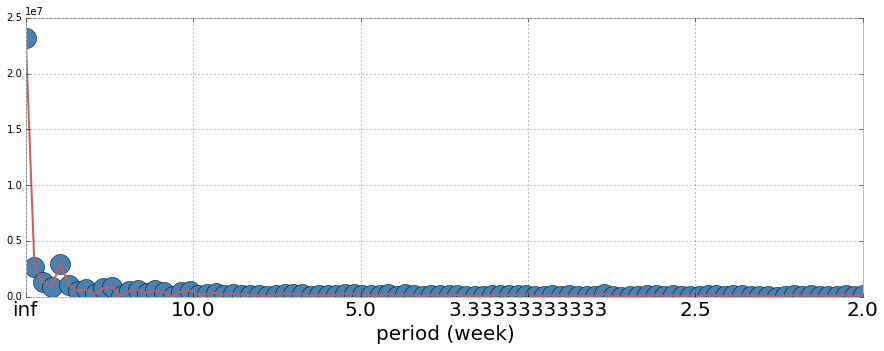

In [124]:
mta_allsum =pd.DataFrame(np.nansum(mta, axis=1))
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1
ax.plot(np.fft.rfftfreq(194, 1.0), (f), 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

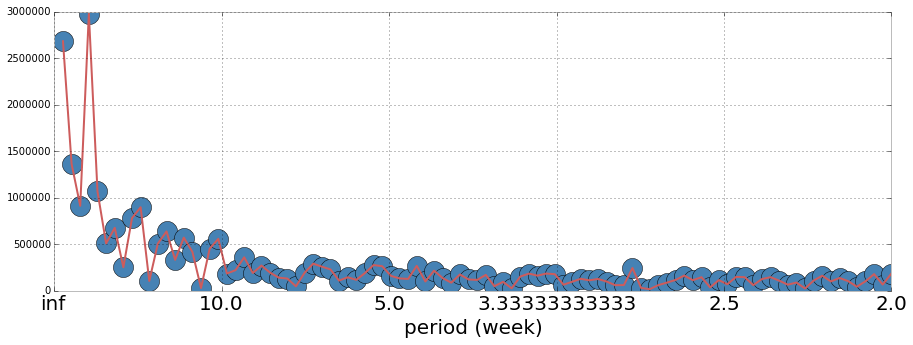

In [125]:
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

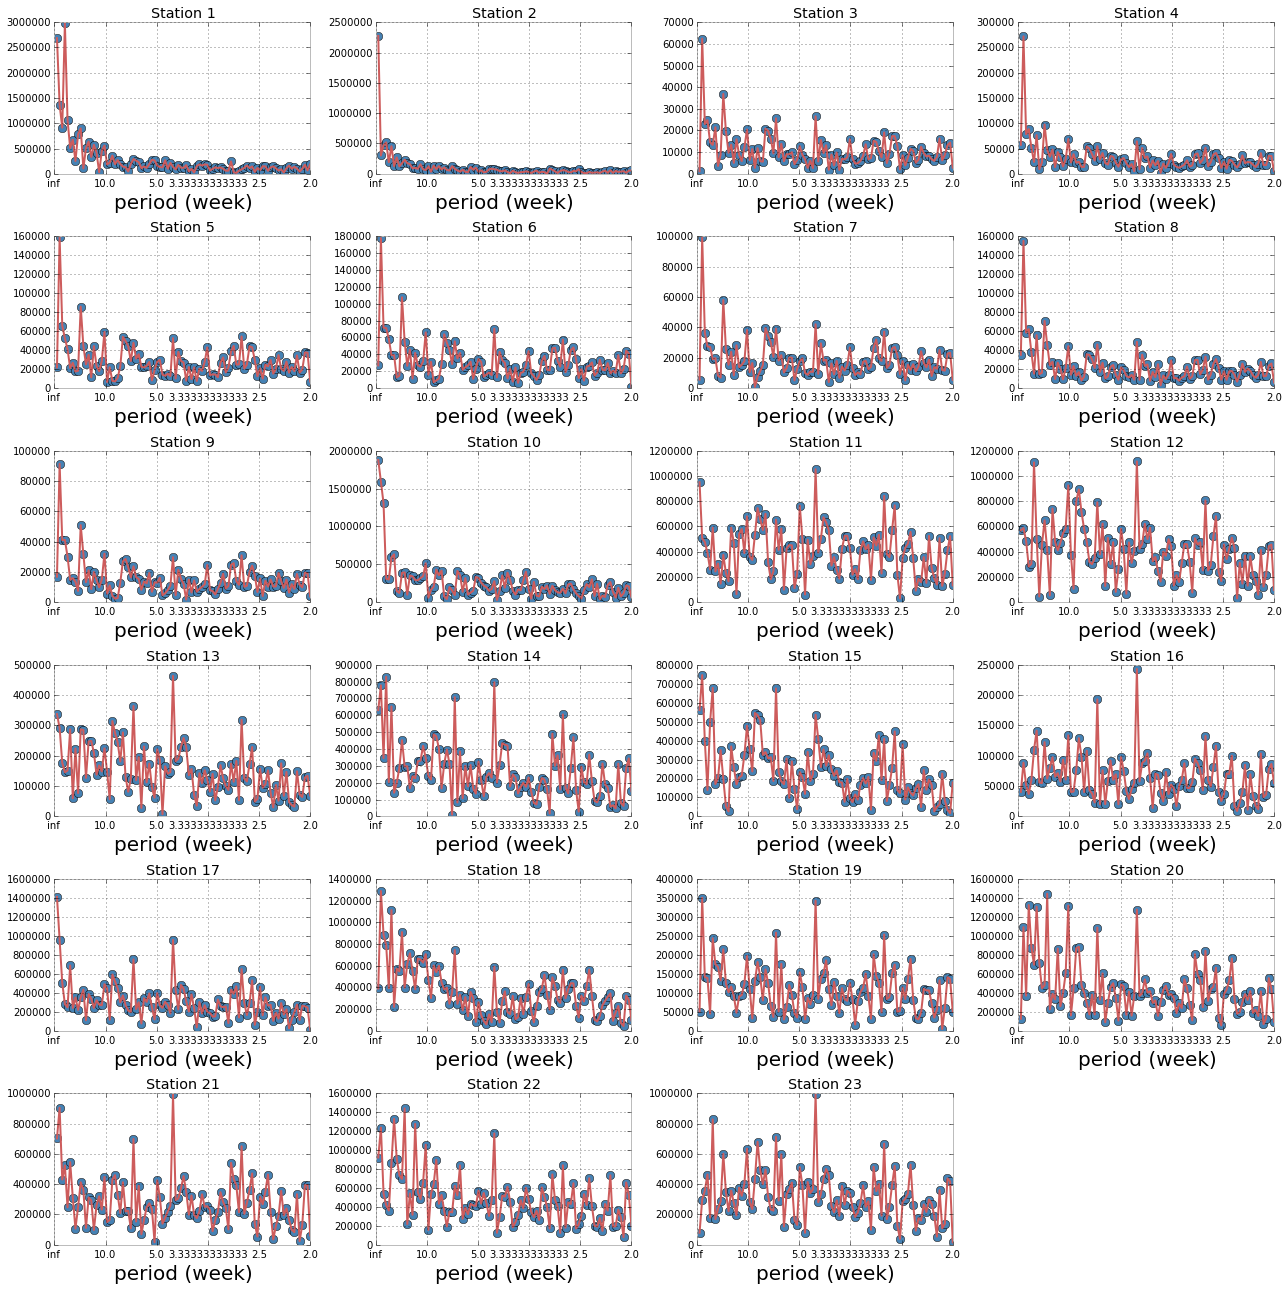

In [126]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            ax.set_title("Station %d"%(i*4+j+1))
fig.tight_layout()

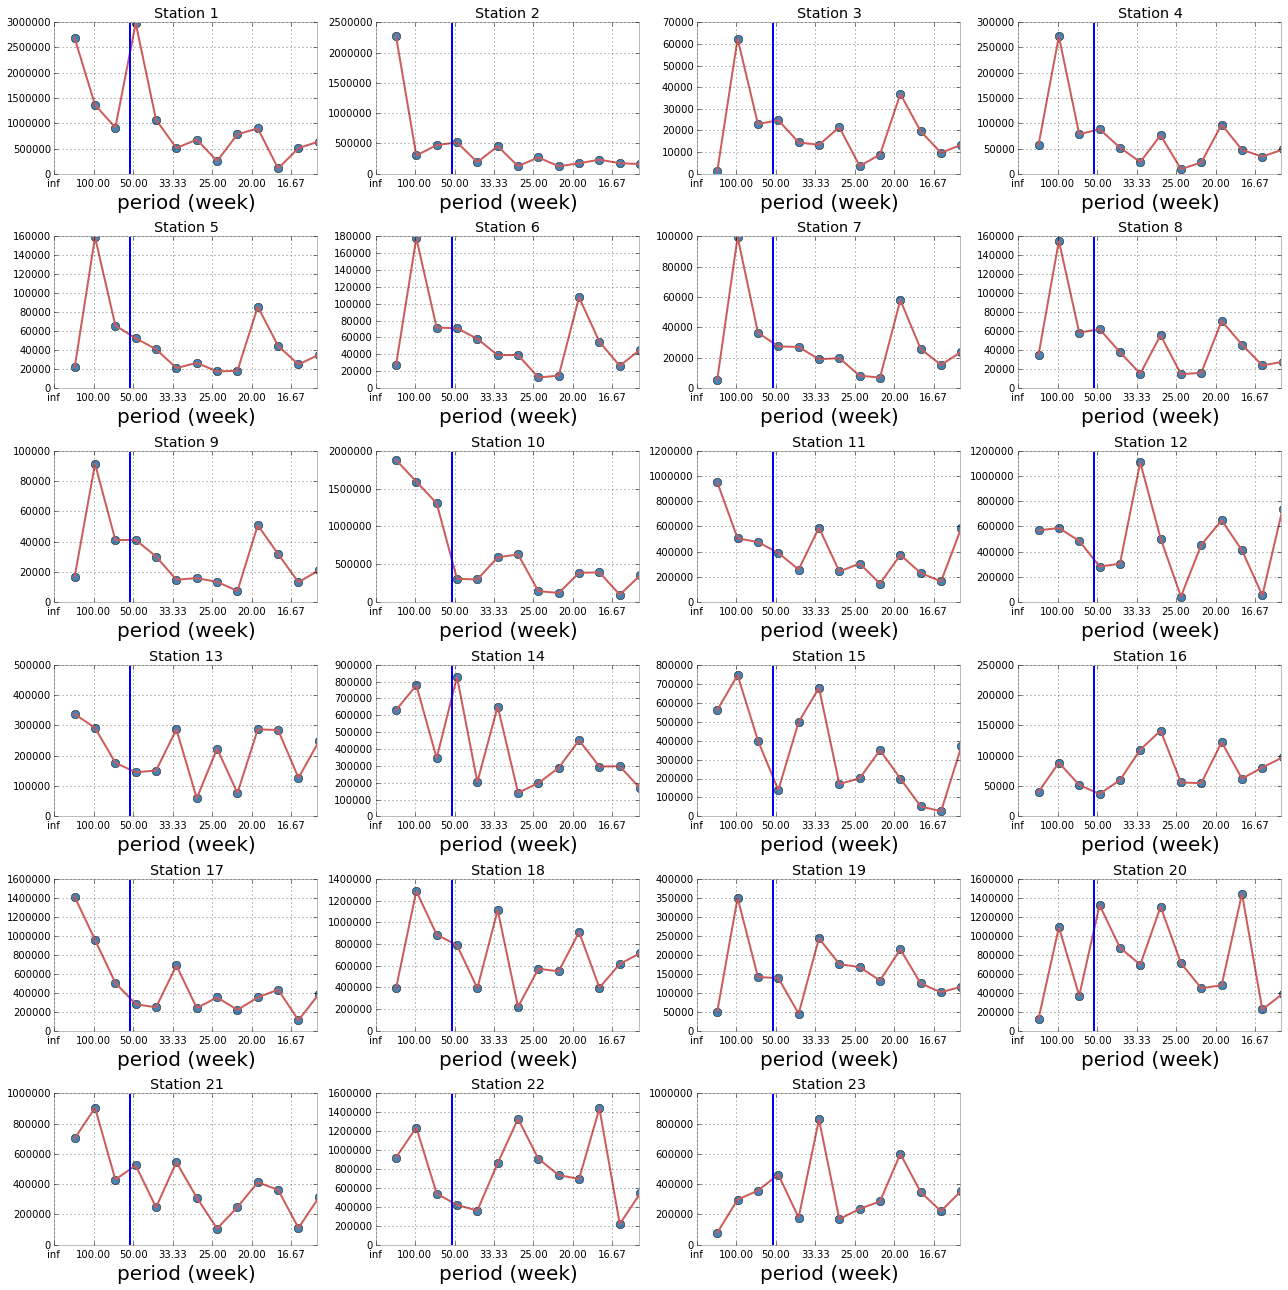

In [127]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
annual = np.zeros(600)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xlim(0,1.0/15)
            ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            plt.axvline(1.0/52)
            ax.set_title("Station %d"%(i*4+j+1))
fig.tight_layout()

In [128]:
annual = np.zeros(600)
for i in range(600):
    annual[i] = np.abs(np.fft.rfft(mta_allsum.loc[i,:])[4])

In [129]:
from operator import itemgetter
indices, L_sorted = zip(*sorted(enumerate(annual), key=itemgetter(1)))
print "The Station's with the most prominent annual periodicity are: %d, %d, %d, %d"%(indices[599], 
                                                                                     indices[598],
                                                                                     indices[597],
                                                                                     indices[596])

The Station's with the most prominent annual periodicity are: 0, 194, 150, 327


### EXTRA CREDIT: Cluster.

Cluster the time series, i.e. identify groups of time series that look similar among each other. 

### My comment:

Doesn't sound like a good idea to use k-means on time series data. k-means is designed for low-dimensional spaces with a (meaningful) euclidean distance. It is not very robust towards outliers, as it puts squared weight on them. 

DWT distance is the way to go for time series.

Resources: http://nbviewer.ipython.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

In [130]:
from sklearn import cluster, covariance, manifold

In [131]:
tots = mta.transpose(2,0,1).reshape(mta.shape[2], mta.shape[1]*mta.shape[0]).T
tots = tots[tots.std(1)>0]
data = tots.copy()
data /= data.std(axis=0)

In [132]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [133]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return sqrt(LB_sum)

In [134]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

In [ ]:
## It took plenty of time running it. Try if you want.
'''
centroids=k_means_clust(data,10,10,4)
for i in centroids:
    
    plt.plot(i)

plt.show()
'''
